In [ ]:
!pip install prophet

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
PJME = pd.read_csv('/content/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
PJME.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


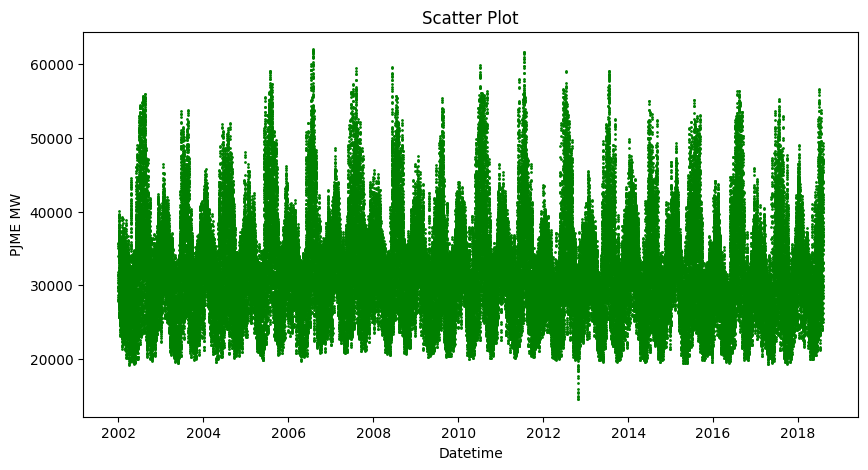

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(PJME.index, PJME['PJME_MW'], s=1, color='GREEN')
plt.title('Scatter Plot')
plt.xlabel('Datetime')
plt.ylabel('PJME MW')
plt.show()

In [5]:
def create_features(df, label=None):
    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

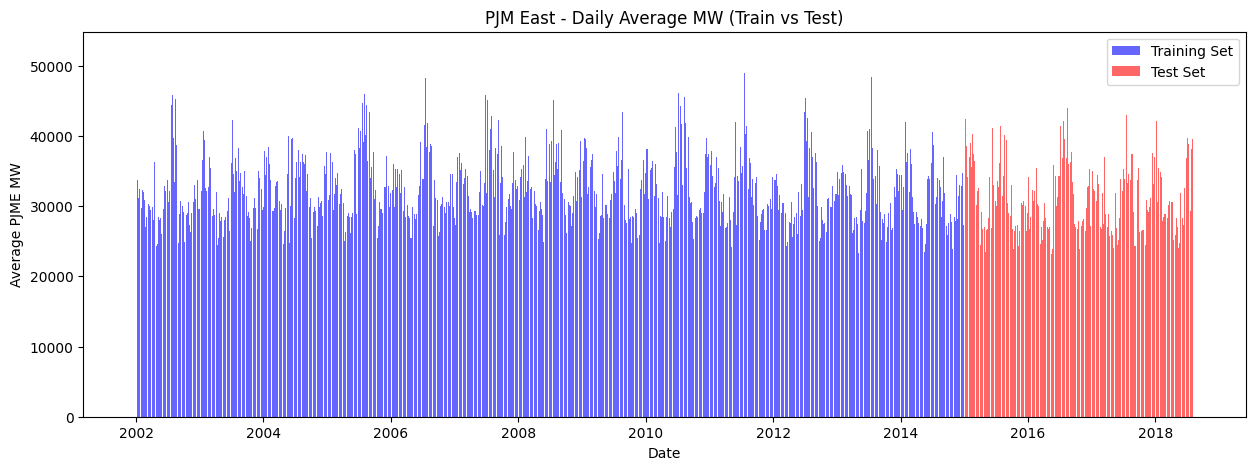

In [7]:
# train-test-split
split_date = '1-Jan-2015'
pjme_train = PJME.loc[PJME.index <= split_date].copy()
pjme_test =PJME.loc[PJME.index > split_date].copy()

pjme_train['date'] = pjme_train.index.date
pjme_test['date'] = pjme_test.index.date

train_daily = pjme_train.groupby('date')['PJME_MW'].mean()
test_daily = pjme_test.groupby('date')['PJME_MW'].mean()

plt.figure(figsize=(15, 5))
plt.bar(train_daily.index, train_daily.values, label='Training Set', color='blue', alpha=0.6)
plt.bar(test_daily.index, test_daily.values, label='Test Set', color='red', alpha=0.6)
plt.title('PJM East - Daily Average MW (Train vs Test)')
plt.xlabel('Date')
plt.ylabel('Average PJME MW')
plt.legend()
plt.show()


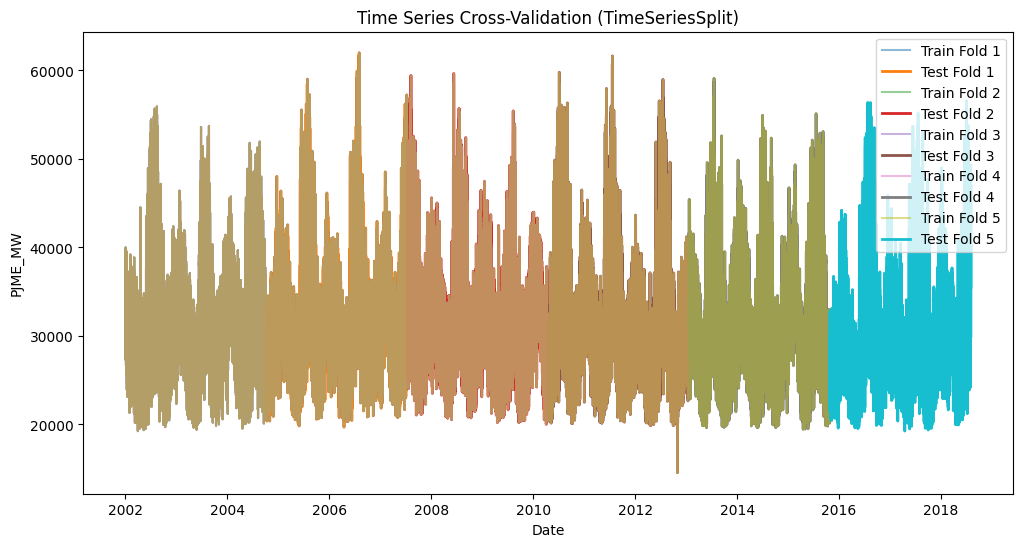

In [21]:
#train test split
'''split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()'''
'''# Total number of rows
total_rows = len(PJME)

# Compute 80% index
train_size = int(total_rows * 0.8)

# Sort by index if it's a time series (important for time order)
pjme_sorted = PJME.sort_index()

# Perform strict 80-20 split
pjme_train = pjme_sorted.iloc[:train_size].copy()
pjme_test = pjme_sorted.iloc[train_size:].copy()

# Optional: Visualize the split
pjme_test.rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10, 5), title='PJM East - Strict 80-20 Split', style='.', ms=1)

plt.show()'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Example PJME dataset (replace with your actual DataFrame)
# Assuming 'pjme' has datetime index and 'PJME_MW' as target column

# Sort by datetime index to ensure correct order
pjme_sorted = PJME.sort_index()

# Initialize TimeSeriesSplit with 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the splits
plt.figure(figsize=(12, 6))

for fold, (train_index, test_index) in enumerate(tscv.split(pjme_sorted)):

    # Extract train and test sets
    train = pjme_sorted.iloc[train_index]
    test = pjme_sorted.iloc[test_index]

    # Plot training set
    plt.plot(train.index, train['PJME_MW'], label=f'Train Fold {fold+1}', alpha=0.5)

    # Plot testing set
    plt.plot(test.index, test['PJME_MW'], label=f'Test Fold {fold+1}', linewidth=2)

plt.title('Time Series Cross-Validation (TimeSeriesSplit)')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()



In [23]:
total_rows = len(PJME)
train_rows = len(pjme_train)
test_rows = len(pjme_test)

train_pct = train_rows / total_rows * 100
test_pct = test_rows / total_rows * 100

print(f"Training set: {train_pct:.2f}%")
print(f"Test set: {test_pct:.2f}%")


Training set: 80.00%
Test set: 20.00%


In [24]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
model = Prophet()
model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplqu0viij/2ivqbnv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplqu0viij/lx8c8099.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64407', 'data', 'file=/tmp/tmplqu0viij/2ivqbnv8.json', 'init=/tmp/tmplqu0viij/lx8c8099.json', 'output', 'file=/tmp/tmplqu0viij/prophet_model4elm_62r/prophet_model-20250704191130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
                              .rename(columns={'Datetime':'ds',
                                    'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-04-09 15:00:00,31975.680830,27944.882824,37026.028226,31975.680830,31975.680830,520.033550,520.033550,520.033550,2984.444953,...,1095.284381,1095.284381,1095.284381,-3559.695784,-3559.695784,-3559.695784,0.0,0.0,0.0,32495.714381
1,2015-04-09 16:00:00,31975.688973,27899.723432,37048.346121,31975.688973,31975.688973,640.854246,640.854246,640.854246,3121.588424,...,1082.420353,1082.420353,1082.420353,-3563.154531,-3563.154531,-3563.154531,0.0,0.0,0.0,32616.543219
2,2015-04-09 17:00:00,31975.697115,28401.370934,37322.890932,31975.697115,31975.697115,926.580486,926.580486,926.580486,3423.316433,...,1069.882063,1069.882063,1069.882063,-3566.618010,-3566.618010,-3566.618010,0.0,0.0,0.0,32902.277601
3,2015-04-09 18:00:00,31975.705257,28647.063152,37956.194739,31975.705257,31975.705257,1406.560821,1406.560821,1406.560821,3919.007866,...,1057.639124,1057.639124,1057.639124,-3570.086169,-3570.086169,-3570.086169,0.0,0.0,0.0,33382.266079
4,2015-04-09 19:00:00,31975.713400,29455.180629,38416.892239,31975.713400,31975.713400,1864.330812,1864.330812,1864.330812,4392.260640,...,1045.629129,1045.629129,1045.629129,-3573.558957,-3573.558957,-3573.558957,0.0,0.0,0.0,33840.044212


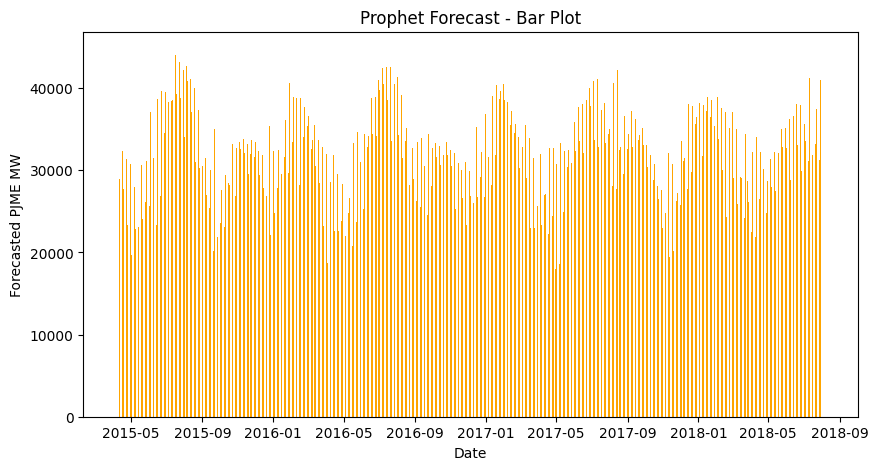

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(pjme_test_fcst['ds'], pjme_test_fcst['yhat'], color='orange', width=0.02)
plt.title('Prophet Forecast - Bar Plot')
plt.xlabel('Date')
plt.ylabel('Forecasted PJME MW')
plt.show()

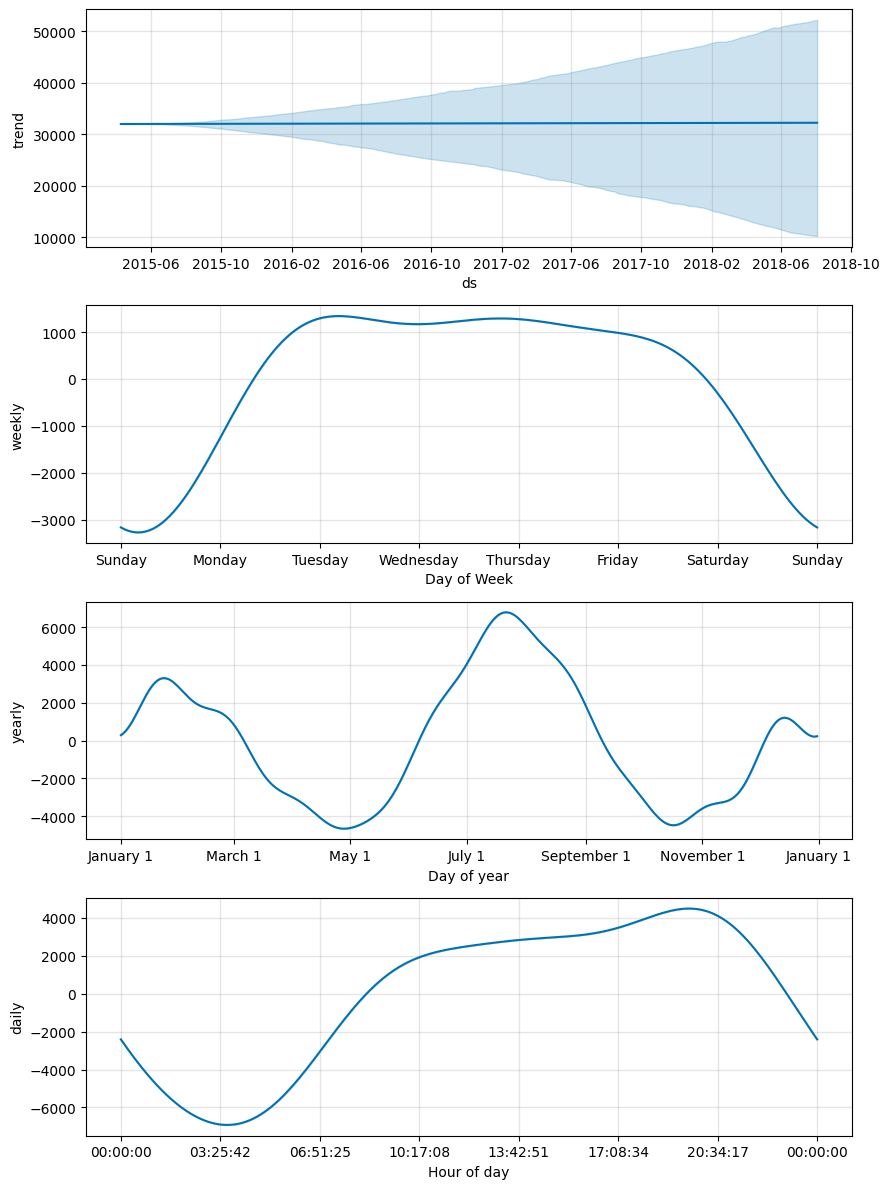

In [19]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

In [ ]:
 # Compare Forecast to Actuals

In [28]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

np.float64(4152.650823435447)

In [29]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

3319.0129640026025

In [30]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(10.738705382661857)

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

holidays = cal.holidays(start=PJME.index.min(),end=PJME.index.max(),return_name=True)
holiday_df = pd.DataFrame(data=holidays,columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [33]:
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplqu0viij/d3igho9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplqu0viij/gas79x6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3826', 'data', 'file=/tmp/tmplqu0viij/d3igho9n.json', 'init=/tmp/tmplqu0viij/gas79x6d.json', 'output', 'file=/tmp/tmplqu0viij/prophet_model6pjw3cd1/prophet_model-20250704191702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:17:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
# Prediction on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

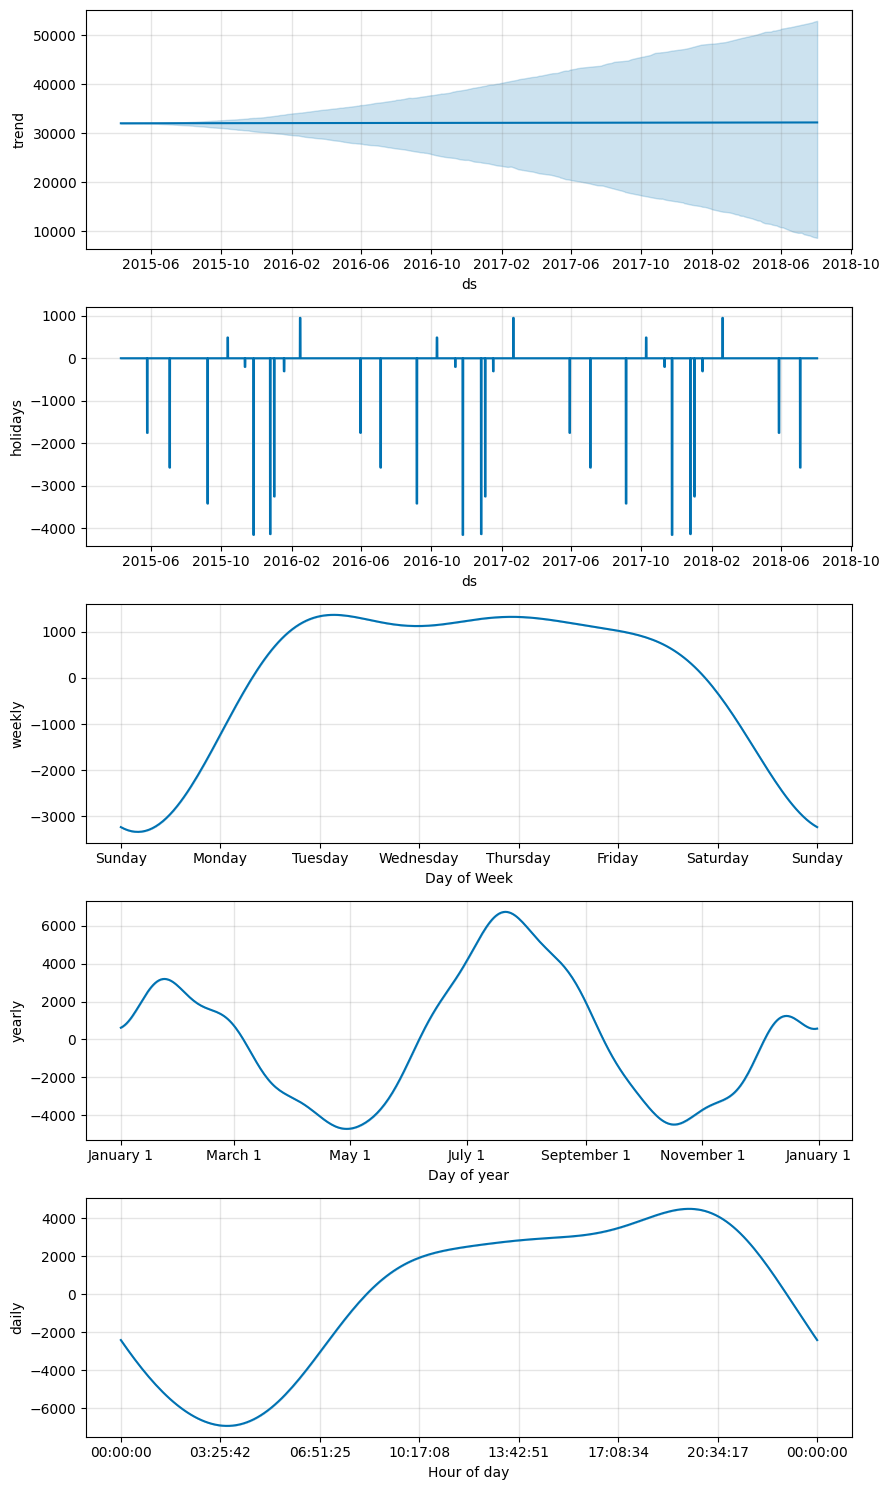

In [35]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

In [36]:
# Predict the future
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-04-09 15:00:00,32540.076792
1,2015-04-09 16:00:00,32659.679463
2,2015-04-09 17:00:00,32943.929090
3,2015-04-09 18:00:00,33422.188895
4,2015-04-09 19:00:00,33878.035697


from matplotlib import pyplot as plt
_df_0['yhat'].plot(kind='hist', bins=20, title='yhat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ds']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ds'}, axis=1)
              .sort_values('ds', ascending=True))
  xs = counted['ds']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['yhat']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'yhat'}, axis=1)
              .sort_values('yhat', ascending=True))
  xs = counted['yhat']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('yhat', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('yhat')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['yhat'].plot(kind='line', figsize=(8, 4), title='yhat')
plt.gca().spines[['top', 'right']].set_visible(False)

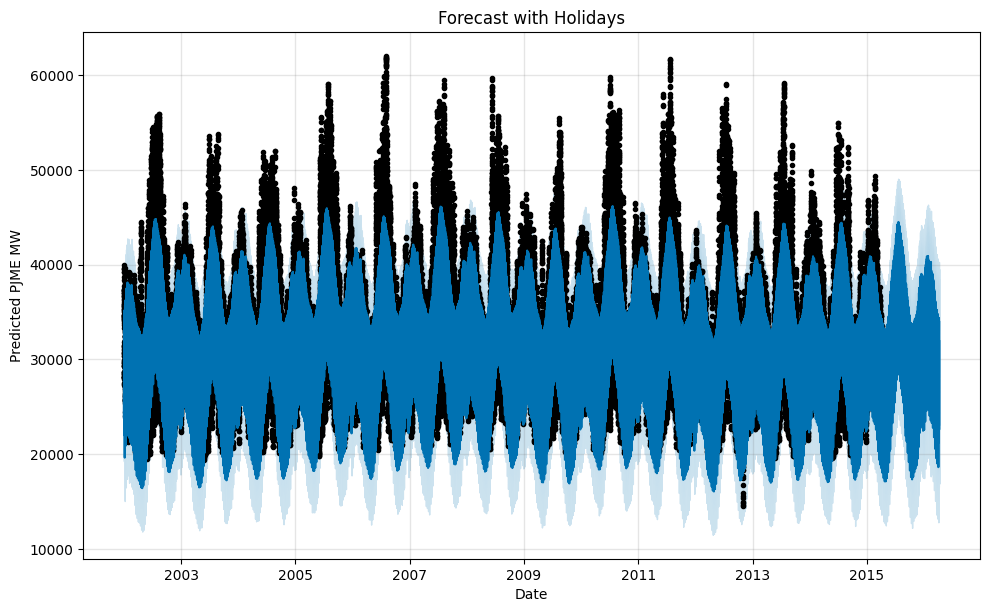

In [37]:
# Generation of future dataframe
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=True)

forecast = model_with_holidays.predict(future)

# Plot of full forecast (history + future)
fig = model_with_holidays.plot(forecast)
plt.title('Forecast with Holidays')
plt.xlabel('Date')
plt.ylabel('Predicted PJME MW')
plt.show()


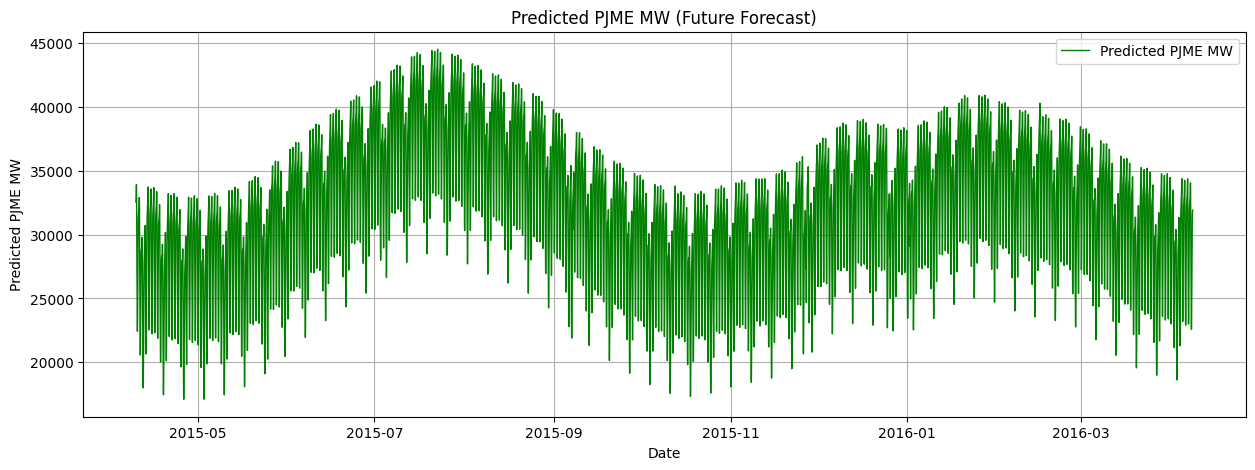

In [38]:
# Generate future dataframe without historical data
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)

forecast = model_with_holidays.predict(future)

# plot of predicted values only
plt.figure(figsize=(15, 5))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted PJME MW', color='green', linewidth=1)
plt.title('Predicted PJME MW (Future Forecast)')
plt.xlabel('Date')
plt.ylabel('Predicted PJME MW')
plt.legend()
plt.grid(True)
plt.show()
